In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pkg_resources

from debvader import DeblendField, IterativeDeblendField

from debvader.model.model import load_deblender
from debvader.deblend_cutout.deblender import deblend

# TODO finish updating to new architecture

2024-11-05 03:16:58.348917: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-05 03:16:58.372732: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-05 03:16:58.881923: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### Deblend stamps randomly generated from DC2 data

Load 10 DC2 images centred on galaxy. They have been generated using this notebook: https://github.com/BastienArcelin/dc2_img_generation/blob/main/notebooks/dc2_stamps_and_corresponding_parameters.ipynb

In [3]:
data_folder_path = pkg_resources.resource_filename('debvader', "data/")
image_path = os.path.join(data_folder_path + 'dc2_imgs/imgs_dc2.npy')
images = np.load(image_path, mmap_mode = 'c')

Visualize some of the images

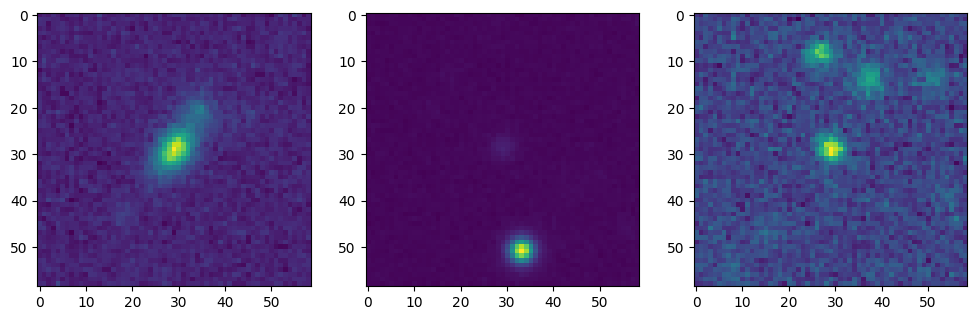

In [4]:
fig, axes = plt.subplots(1,3, figsize = (12, 4))
for i in range (3):
    axes[i].imshow(images[i,:,:,2]) # We plot only r-band here, but the images are multi-bands (ugrizy)

Now we can load the deblender

In [5]:
# First, define the parameters of the neural network, for this version of debvader, they are as follow:
nb_of_bands = 6
input_shape = (59, 59, nb_of_bands)
latent_dim = 32
filters = [32,64,128,256]
kernels = [3,3,3,3]

# We will load the weights of the network trained on DC2 images
survey = "dc2"

In [ ]:
# Load the network using the load_deblender function
net, encoder, decoder, z = load_deblender(survey, input_shape, latent_dim, filters, kernels, return_encoder_decoder_z=True)

In [ ]:
# We can visualize the network
net.summary()

We now have everything to do the deblending. Let's use our network to deblend the DC2 images

In [ ]:
output_images_mean, output_images_distribution = deblend(net, images)

Here the network outputs a distribution over the pixels for each pixel in each filter, this is why both the mean image and the corresponding distribution is outputed.

Let's first visualize the mean images outputed by debvader.

In [ ]:
fig, axes = plt.subplots(3,3, figsize = (12, 12))
for i in range (3):
    axes[i,0].imshow(images[i,:,:,2]) # We plot only r-band here, but the images are multi-bands (ugrizy)
    axes[i,1].imshow(output_images_mean[i,:,:,2]) # We plot only r-band here, but the output images are multi-bands (ugrizy)
    axes[i,2].imshow(images[i,:,:,2]-output_images_mean[i,:,:,2])

In [ ]:
import pandas as pd
root_dir = "/pbs/home/b/barcelin/sps_link/data/dc2_test/24.5/test/"

images_noiseless = np.load(root_dir+'img_noiseless_sample_2.npy', mmap_mode = 'c')
images_noisy = np.load(root_dir+'img_cropped_sample_2.npy', mmap_mode = 'c')
data = pd.read_csv(root_dir+'img_noiseless_data_2.csv')

In [ ]:
latent_space_distribution_noiseless = z(tf.cast(images_noiseless[:1000], tf.float32))
latent_space_distribution_noisy = z(tf.cast(images_noisy[:1000], tf.float32))

#print(latent_space_distribution)

In [ ]:
plt.plot(np.linspace(0,32, 32), np.mean(latent_space_distribution_noiseless.stddev().numpy() ,axis = 0), '.', color = 'blue', alpha = 0.3)
plt.plot(np.linspace(0,32, 32), np.mean(latent_space_distribution_noiseless.stddev().numpy() ,axis = 0), '.', color = 'red', alpha = 0.3)

In [ ]:
fig, axes = plt.subplots(1,2 ,figsize = (20,5))

for i in range (2):
    _ = axes[i].hist(np.concatenate(latent_space_distribution_noiseless.stddev().numpy(), axis = 0), bins = 100, alpha = 0.3 , label = 'noiseless')
    _ = axes[i].hist(np.concatenate(latent_space_distribution_noisy.stddev().numpy(), axis = 0), bins = 100, alpha = 0.3, label = 'blended and noisy')

axes[0].legend()
axes[1].set_xlim(0, 0.8)
axes[1].set_ylim(0, 1000)

plt.title('standard deviation of latent space')

In [ ]:
fig, axes = plt.subplots(1,2 ,figsize = (20,5))

for i in range (2):
    _ = axes[i].hist(np.concatenate(latent_space_distribution_noiseless.mean().numpy(), axis = 0), bins = 100, alpha = 0.3 , label = 'noiseless')
    _ = axes[i].hist(np.concatenate(latent_space_distribution_noisy.mean().numpy(), axis = 0), bins = 100, alpha = 0.3, label = 'blended and noisy')

axes[0].legend()
axes[1].set_xlim(-5, 5)
axes[1].set_yscale('log')

plt.title('means of latent space')

Now let's visualise as a function of blendedness

In [ ]:
latent_space_distribution_noiseless.stddev().numpy().shape

In [ ]:
fig, axes = plt.subplots(1,2 ,figsize = (20,5))

for i in range (2):
        _ = axes[i].plot(data['blendedness'][:1000], np.mean(latent_space_distribution_noiseless.stddev().numpy(), axis = 1), '.',color = 'blue', alpha = 0.3 , label = 'noiseless')
        _ = axes[i].plot(data['blendedness'][:1000], np.mean(latent_space_distribution_noisy.stddev().numpy(), axis = 1),'.', color = 'red', alpha = 0.3 , label = 'noisy')

axes[0].legend()
axes[0].set_xscale('log')
axes[0].set_title('mean std in latent space as a function of blendedness')

Now we can look at what the images of the standard deviation look like for each example, and how we can sample this distribution in each pixel.

In [ ]:
output_uncertainty_mean = output_images_distribution.mean().numpy() # Extract the mean of the distribution. Same image as output_images_mean.
output_uncertainty_std = output_images_distribution.stddev().numpy() # Extract the standard deviation of the distribution.
output_uncertainty_sample = tf.math.reduce_mean(output_images_distribution.sample(100), axis = 0).numpy() # Sample 100 times the distribution in each pixel and produce a mean image.

In [ ]:
fig, axes = plt.subplots(3,6, figsize = (28, 12))

for i in range (3):
    f1 = axes[i,0].imshow(images[i,:,:,2])
    f2 = axes[i,1].imshow(output_uncertainty_mean[i,:,:,2])
    f3 = axes[i,2].imshow(output_uncertainty_std[i,:,:,2])
    f4 = axes[i,3].imshow(output_uncertainty_sample[i,:,:,2])
    f5 = axes[i,4].imshow(images[i,:,:,2] - output_uncertainty_mean[i,:,:,2])
    f6 = axes[i,5].imshow(images[i,:,:,2] - output_uncertainty_sample[i,:,:,2])
    fig.colorbar(f1, ax = axes[i,0])
    fig.colorbar(f2, ax = axes[i,1])
    fig.colorbar(f3, ax = axes[i,2])
    fig.colorbar(f4, ax = axes[i,3])
    fig.colorbar(f5, ax = axes[i,4])
    fig.colorbar(f6, ax = axes[i,5])

    axes[i,0].set_title('Input')
    axes[i,1].set_title('output mean flux')
    axes[i,2].set_title('output std of flux per pixel')
    axes[i,3].set_title('output mean \n of 100 sample')
    axes[i,4].set_title('target - output mean')
    axes[i,5].set_title('target - output \n 100 sample')